In [2]:
import morfeus

import rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem, Draw, rdMolDescriptors
from rdkit.Chem.Draw import SimilarityMaps

from chiralizer import chiralizer
import sascorer

from pathlib import Path

import matplotlib.pyplot as plt

import os
from adjustText import adjust_text
%matplotlib inline

import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

import torch
import torch.nn.functional as f

importing all sidechains

In [3]:
smiles_file = open('sidechain_smiles.smi', 'r')
smiles = smiles_file.read().splitlines()

## analyzing properties of chiral peptoids

separating chiral and achiral peptoids

In [4]:
chiral_smiles = [chiralizer(smiles[i])[1] for i in range(len(smiles)) if chiralizer(smiles[i])[0]]

In [5]:
chiral_directory = Path('C:/Users/Mel/Box/School/Internships/REU/PeptoidsProject/data/chiral_xyz/')

In [6]:
del chiral_smiles[9] # remove achiral flaw ['N[C@H](C)(C)C', 'N[C@@H](C)(C)C']

converting smiles to xyz done on conda command line

### calculating properties

buried volume, dispersion p_int, and solvent accessible surface area data

In [46]:
# list of properties
bv_list, disp_list, sasa_list = [], [], []

for filename in os.listdir(chiral_directory):
    if filename != 'mol10a.xyz' and filename != 'mol10b.xyz':
        if filename.endswith('.xyz'):
            elements, coordinates = morfeus.read_xyz('C:/Users/Mel/Box/School/Internships/REU/PeptoidsProject/data/chiral_xyz/' + filename)

            # appending results to lists
            bv_list.append((os.path.splitext(filename)[0], morfeus.BuriedVolume(elements, coordinates, 1).fraction_buried_volume))
    #        cone_list.append((os.path.splitext(filename)[0], morfeus.ConeAngle(elements, coordinates, 1).cone_angle)) # Exception: ('Atoms within vdW radius of central atom:', '2 6 7')
            disp_list.append((os.path.splitext(filename)[0], morfeus.Dispersion(elements, coordinates).p_int)) # P_int value
            sasa_list.append((os.path.splitext(filename)[0], morfeus.SASA(elements, coordinates).area)) # 

In [16]:
left_bv = [i[1] for i in bv_list if 'a' in i[0]]
right_bv = [i[1] for i in bv_list if 'b' in i[0]]

left_disp = [i[1] for i in disp_list if 'a' in i[0]]
right_disp = [i[1] for i in disp_list if 'b' in i[0]]

left_sasa = [i[1] for i in sasa_list if 'a' in i[0]]
right_sasa = [i[1] for i in sasa_list if 'b' in i[0]]

number of hydrogen bonds data

In [8]:
left_bonds = []
right_bonds = []
for chiral_mol in chiral_smiles:
    if chiral_mol != ['N[C@H](C)(C)C', 'N[C@@H](C)(C)C']: # achiral molecule, flaw in chiralizer.py
        mol1 = rdkit.Chem.MolFromSmiles(chiral_mol[0])
        mol2 = rdkit.Chem.MolFromSmiles(chiral_mol[1])
        left_bonds.append(rdkit.Chem.rdMolDescriptors.CalcNumHBD(mol1))
        right_bonds.append(rdkit.Chem.rdMolDescriptors.CalcNumHBD(mol2))

xtb data

In [9]:
chiral_xtb_np = np.load('data/chiral_xtb_data.npy', allow_pickle=True) 

In [10]:
chiral_xtb = chiral_xtb_np.tolist() # LUMO, Q+, H_idx

In [11]:
del chiral_xtb[18] # removing achiral flaw
del chiral_xtb[19]

In [12]:
left_xtb = []
right_xtb = []

while chiral_xtb:
    right_xtb.append(chiral_xtb.pop())
    left_xtb.append(chiral_xtb.pop())

In [13]:
left_xtb.reverse()
right_xtb.reverse()

In [14]:
left_lumo = [i[0] for i in left_xtb]
left_Q = [i[1] for i in left_xtb]
left_H = [i[2] for i in left_xtb]

right_lumo = [i[0] for i in right_xtb]
right_Q = [i[1] for i in right_xtb]
right_H = [i[2] for i in right_xtb]

synthetic accessibility score

In [15]:
sa_list = []
left_sa = []
right_sa = []

for i in chiral_smiles:
    if i != ['N[C@H](C)(C)C', 'N[C@@H](C)(C)C']: # achiral molecule, flaw in chiralizer.py
        left = rdkit.Chem.MolFromSmiles(i[0])
        right = rdkit.Chem.MolFromSmiles(i[1])

        l_sco = sascorer.calculateScore(left)
        r_sco = sascorer.calculateScore(right)

        sa_list.append(l_sco)
        sa_list.append(r_sco)
      
while sa_list:
    right_sa.append(sa_list.pop())
    left_sa.append(sa_list.pop())
    
left_sa.reverse()
right_sa.reverse()

In [17]:
labels = [i[0] for i in bv_list if 'a' in i[0]]

### plotting

observing structure similarity in properties

In [18]:
# dictionary of properties
chiral_props = {
    'buried volume' : (left_bv, right_bv),
    'SASA area' : (left_sasa, right_sasa),
    'dispersion descriptor p_int' : (left_disp, right_disp),
    'LUMO' : (left_lumo, right_lumo),
    'Q+' : (left_Q, right_Q),
    '# H+ bond donors' : (left_bonds, right_bonds),
    'synthetic accessibility score' : (left_sa, right_sa)
} 

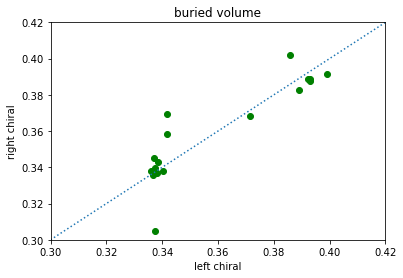

tensor MSE: tensor(0.0166, dtype=torch.float64)
manual MSE:  0.016561908749077772


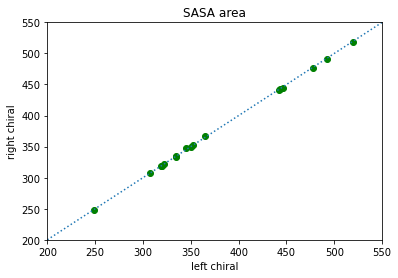

tensor MSE: tensor(2.0350e-05, dtype=torch.float64)
manual MSE:  2.0350176820721944e-05


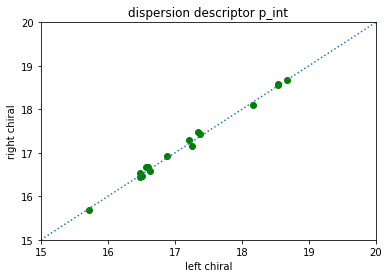

tensor MSE: tensor(0.0002, dtype=torch.float64)
manual MSE:  0.0001829308165733891


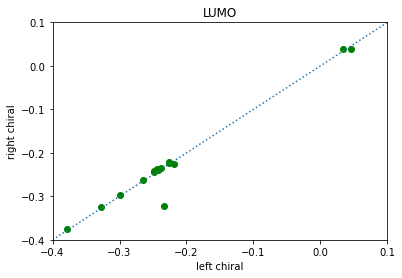

tensor MSE: tensor(0.0027, dtype=torch.float64)
manual MSE:  0.0026878335776740997


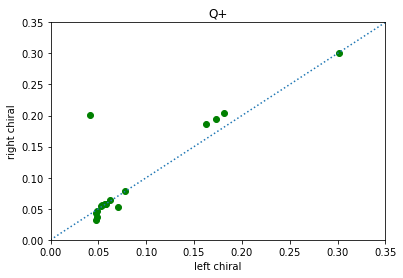

tensor MSE: tensor(0.0225, dtype=torch.float64)
manual MSE:  0.02252030548398492


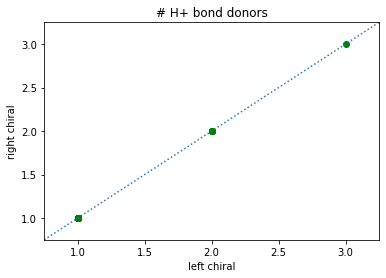

tensor MSE: tensor(0., dtype=torch.float64)
manual MSE:  0.0


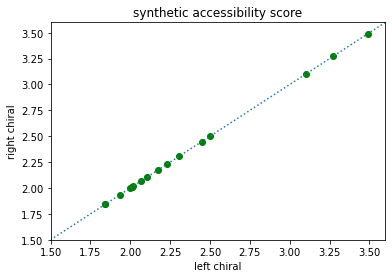

tensor MSE: tensor(0., dtype=torch.float64)
manual MSE:  0.0


In [19]:
for key in chiral_props:
    plt.scatter(chiral_props[key][0], chiral_props[key][1], c='g', )
    plt.axline([0, 0], [1, 1], linestyle=':')
    plt.xlabel("left chiral")
    plt.ylabel("right chiral")
    plt.title(key)
    if key == "buried volume":
        plt.axis([0.3, 0.42, 0.3, 0.42])
    elif key == "dispersion descriptor p_int":
        plt.axis([15, 20, 15, 20])
    elif key == "SASA area":
        plt.axis([200, 550, 200, 550])
    elif key == "LUMO":
        plt.axis([-0.4, 0.1, -0.4, 0.1])
    elif key == "Q+":
        plt.axis([0.0, 0.35, 0.0, 0.35])
    elif key == "synthetic accessibility score":
        plt.axis([1.5, 3.6, 1.5, 3.6])
    elif key == "# H+ bond donors":
        plt.axis([0.75, 3.25, 0.75, 3.25])
    
#     texts = [plt.text(chiral_props[key][0][i], chiral_props[key][1][i], label.replace("a", "")) for i, 
#             label in enumerate(labels)
#             ]
#    adjust_text(texts)
        
    plt.show()
        
    # MSE
    scaler = MinMaxScaler()
    all_data = np.array(chiral_props[key][0] + chiral_props[key][1])
    scaled_data = scaler.fit_transform(all_data.reshape(-1, 1))
    
    left_prop = scaled_data[:17]
    right_prop = scaled_data[17:]

    print("tensor MSE:", f.mse_loss(torch.tensor(left_prop), torch.tensor(right_prop)))
    print("manual MSE: ", np.sum((left_prop - right_prop) ** 2) / 17)

buried volume steric maps for N\[C@H\](Cc1ccccc1)C(=O)NCC(F)(F)F && N\[C@@H\](Cc1ccccc1)C(=O)NCC(F)(F)F

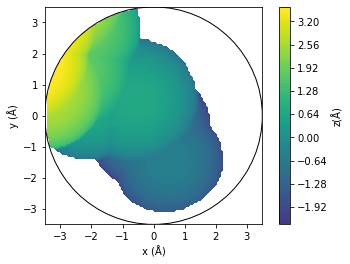

bv:  0.38577967759970183


In [23]:
elements, coordinates = morfeus.read_xyz("C:/Users/Mel/Box/School/Internships/REU/PeptoidsProject/data/chiral_xyz/mol12a.xyz")
bv = morfeus.BuriedVolume(elements, coordinates, 1, z_axis_atoms=[0])
bv.plot_steric_map()
print("bv: ", morfeus.BuriedVolume(elements, coordinates, 1).fraction_buried_volume)

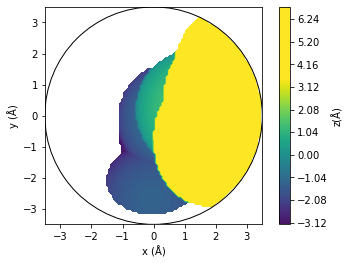

bv:  0.4020627562430116


In [22]:
elements, coordinates = morfeus.read_xyz("C:/Users/Mel/Box/School/Internships/REU/PeptoidsProject/data/chiral_xyz/mol12b.xyz")
bv = morfeus.BuriedVolume(elements, coordinates, 1, z_axis_atoms=[0])
bv.plot_steric_map()
print("bv: ", morfeus.BuriedVolume(elements, coordinates, 1).fraction_buried_volume)

## analyzing properties of methyl vs. amine

### calculating methyl props

In [24]:
methyl_smiles_file = open('methyl_smiles.smi', 'r')
methyl_smiles = methyl_smiles_file.read().splitlines()

In [25]:
methyl_directory = Path('C:/Users/Mel/Box/School/Internships/REU/PeptoidsProject/data/methyl_xyz/')

buried volume, dispersion p_int, and solvent accessible surface area data

In [26]:
# list of properties
bv_methyl, disp_methyl, sasa_methyl = [], [], []

for filename in os.listdir(methyl_directory):
    if filename.endswith('.xyz'):
        elements, coordinates = morfeus.read_xyz('C:/Users/Mel/Box/School/Internships/REU/PeptoidsProject/data/methyl_xyz/' + filename)

        # appending results to lists
        bv_methyl.append(morfeus.BuriedVolume(elements, coordinates, 1).fraction_buried_volume)
#        cone_methyl.append(morfeus.ConeAngle(elements, coordinates, 1).cone_angle) # Exception: ('Atoms within vdW radius of central atom:', '2 6 7')
        disp_methyl.append(morfeus.Dispersion(elements, coordinates).atom_p_int[1]) # P_int value
        sasa_methyl.append(morfeus.SASA(elements, coordinates).area)
#        xtb_methyl.append(morfeus.XTB(elements,coordinates).get_ip(corrected=True)) # corrected ionization potential   # need to dl xtra to work                      

xtb data

In [27]:
methyl_xtb = np.load('data/methyl_xtb_data.npy', allow_pickle=True) 

In [28]:
methyl_lumo = [i[0] for i in methyl_xtb]
methyl_Q = [i[1] for i in methyl_xtb]
methyl_H = [i[2] for i in methyl_xtb]

number of hydrogen bonds data

In [29]:
methyl_bonds = []
for smile in methyl_smiles:
    mol1 = rdkit.Chem.MolFromSmiles(smile)
    methyl_bonds.append(rdkit.Chem.rdMolDescriptors.CalcNumHBD(mol1))

synthetic accessibility score data

In [30]:
methyl_sa = []

for i in methyl_smiles:
    m = rdkit.Chem.MolFromSmiles(i)
    sco = sascorer.calculateScore(m)
    methyl_sa.append(sco)

### calculating amine properties

In [31]:
amine_directory = Path('C:/Users/Mel/Box/School/Internships/REU/PeptoidsProject/data/amine_xyz/')

buried volume, dispersion p_int, and solvent accessible surface area data

In [32]:
# list of properties
bv_amine, disp_amine, sasa_amine = [], [], []

for filename in os.listdir(amine_directory):
    if filename.endswith('.xyz'):
        elements, coordinates = morfeus.read_xyz('C:/Users/Mel/Box/School/Internships/REU/PeptoidsProject/data/amine_xyz/' + filename)

        # appending results to lists
        bv_amine.append(morfeus.BuriedVolume(elements, coordinates, 1).fraction_buried_volume)
#        cone_amine.append(morfeus.ConeAngle(elements, coordinates, 1).cone_angle) # Exception: ('Atoms within vdW radius of central atom:', '2 6 7')
        disp_amine.append(morfeus.Dispersion(elements, coordinates).p_int) # P_int value
        sasa_amine.append(morfeus.SASA(elements, coordinates).area)
#        xtb_amine.append(morfeus.XTB(elements,coordinates).get_ip(corrected=True)) # corrected ionization potential   # need to dl xtra to work                      

xtb data

In [33]:
amine_xtb = np.load('data/amine_xtb_data.npy', allow_pickle=True) 

In [34]:
amine_lumo = [i[0] for i in amine_xtb]
amine_Q = [i[1] for i in amine_xtb]
amine_H = [i[2] for i in amine_xtb]

number of hydrogen bonds data

In [35]:
amine_bonds = []
for smile in smiles:
    mol1 = rdkit.Chem.MolFromSmiles(smile)
    amine_bonds.append(rdkit.Chem.rdMolDescriptors.CalcNumHBD(mol1))

synthetic accessiblity score data

In [36]:
amine_sa = []

for i in smiles:
    m = rdkit.Chem.MolFromSmiles(i)
    sco = sascorer.calculateScore(m)
    amine_sa.append(sco)

### plotting

In [37]:
am_props = {
    'buried volume' : (bv_methyl, bv_amine),
    'SASA area' : (sasa_methyl, sasa_amine),
    'dispersion descriptor p_int' : (disp_methyl, disp_amine),
    'LUMO' : (methyl_lumo, amine_lumo),
    'Q+' : (methyl_Q, amine_Q),
    '# H+ bond donors' : (methyl_bonds, amine_bonds),
    'synthetic accessibility score' : (methyl_sa, amine_sa)
} 

In [38]:
mol_labels = ["mol" + str(i) for i in range(1, 52)]

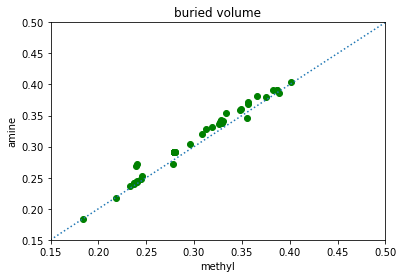

tensor MSE: tensor(0.0019, dtype=torch.float64)
manual MSE:  0.0018673413971450807


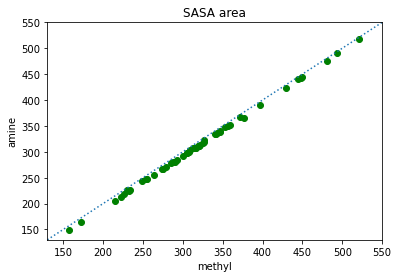

tensor MSE: tensor(0.0004, dtype=torch.float64)
manual MSE:  0.00038997370597063525


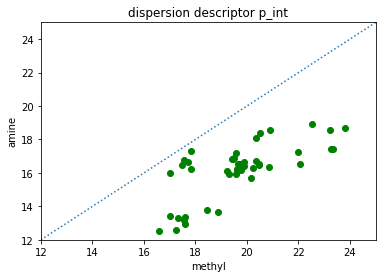

tensor MSE: tensor(0.0711, dtype=torch.float64)
manual MSE:  0.07112717269955925


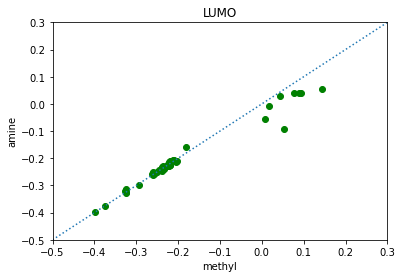

tensor MSE: tensor(0.0027, dtype=torch.float64)
manual MSE:  0.002725497832883591


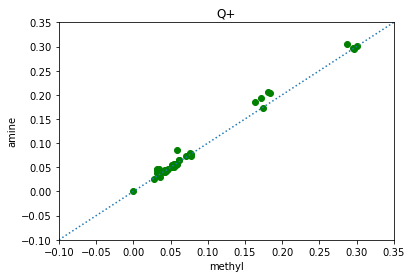

tensor MSE: tensor(0.0008, dtype=torch.float64)
manual MSE:  0.0008302349752486482


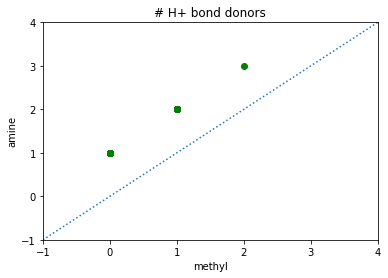

tensor MSE: tensor(0.1111, dtype=torch.float64)
manual MSE:  0.11111111111111109


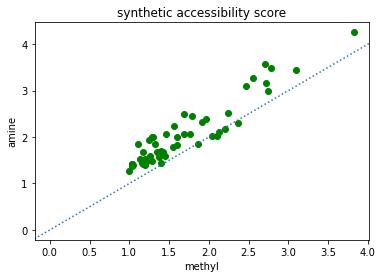

tensor MSE: tensor(0.0176, dtype=torch.float64)
manual MSE:  0.01764160084126104


In [39]:
for key in am_props:
    plt.scatter(am_props[key][0], am_props[key][1], c='g', )
    plt.axline([0, 0], [1, 1], linestyle=':')
    plt.xlabel("methyl")
    plt.ylabel("amine")
    plt.title(key)
    if key == "buried volume":
        plt.axis([0.15, 0.5, 0.15, 0.5])
    elif key == "dispersion descriptor p_int":
        plt.axis([12, 25, 12, 25])
    elif key == "SASA area":
        plt.axis([130, 550, 130, 550])
    elif key == "LUMO":
        plt.axis([-0.5, 0.3, -0.5, 0.3])
    elif key == "Q+":
        plt.axis([-0.1, 0.35, -0.1, 0.35])
    elif key == "# H+ bond donors":
        plt.axis([-1, 4, -1, 4])
#     texts = [plt.text(am_props[key][0][i], am_props[key][1][i], 'mol%s' %i) for i in range(1, 52)]
#     adjust_text(texts)
    plt.show()
    
    # MSE
    scaler = MinMaxScaler()
    all_data = np.array(am_props[key][0] + am_props[key][1])
    scaled_data = scaler.fit_transform(all_data.reshape(-1, 1))
    
    left_prop = scaled_data[:52]
    right_prop = scaled_data[52:]

    print("tensor MSE:", f.mse_loss(torch.tensor(left_prop), torch.tensor(right_prop)))
    print("manual MSE: ", np.sum((left_prop - right_prop) ** 2) / 52)
    
#    adjust_text(texts)
#    for i, label in enumerate(mol_labels):
#        plt.annotate(label, (am_props[key][0][i], am_props[key][1][i]), textcoords="offset points", xytext=(0, 10))

### visualization of dispersion

drawing a similarity map to visualize disperion for NNC(=O)C && CNC(=O)C

amine p_int:  13.980923087061498


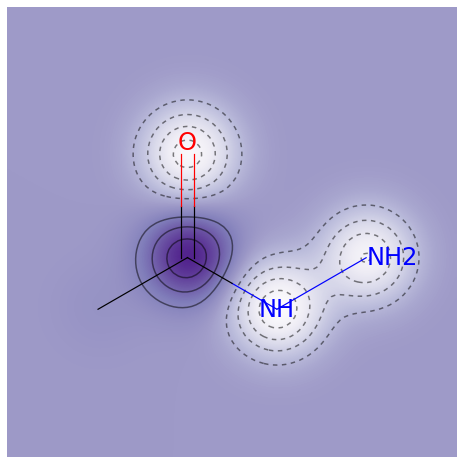

In [43]:
mol = rdkit.Chem.MolFromSmiles(smiles[0])
AllChem.ComputeGasteigerCharges(mol)
contribs = [mol.GetAtomWithIdx(i).GetDoubleProp('_GasteigerCharge') for i in range(mol.GetNumAtoms())]
fig = SimilarityMaps.GetSimilarityMapFromWeights(mol, contribs, colorMap='Purples', contourLines=10)
elements, coordinates = morfeus.read_xyz('C:/Users/Mel/Box/School/Internships/REU/PeptoidsProject/data/amine_xyz/amine1.xyz')
print("amine p_int: ", morfeus.Dispersion(elements, coordinates).atom_p_int[1])

methyl p_int:  17.01752041507288


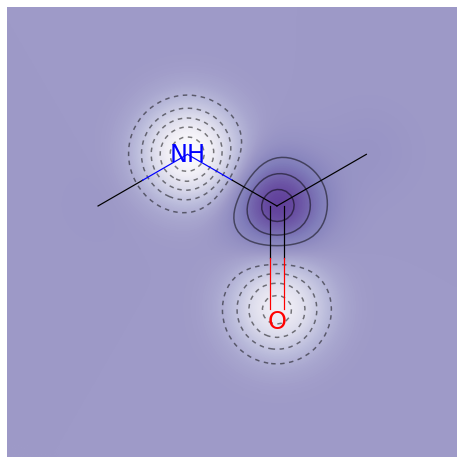

In [44]:
mol = rdkit.Chem.MolFromSmiles(methyl_smiles[0])
AllChem.ComputeGasteigerCharges(mol)
contribs = [mol.GetAtomWithIdx(i).GetDoubleProp('_GasteigerCharge') for i in range(mol.GetNumAtoms())]
fig = SimilarityMaps.GetSimilarityMapFromWeights(mol, contribs, colorMap='Purples', contourLines=10)
elements, coordinates = morfeus.read_xyz('C:/Users/Mel/Box/School/Internships/REU/PeptoidsProject/data/methyl_xyz/methyl1.xyz')
print("methyl p_int: ", morfeus.Dispersion(elements, coordinates).atom_p_int[1])

#### Testing TSNE Plots

In [41]:
methyl_fingerprints = np.zeros((52, 1024))
for i in range(len(methyl_smiles)):
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(rdkit.Chem.MolFromSmiles(methyl_smiles[i]), 2, nBits=1024)
    methyl_fingerprints[i, :] = np.array(fingerprint)

In [42]:
amine_fingerprints = np.zeros((52, 1024))
for i in range(len(smiles)):
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(rdkit.Chem.MolFromSmiles(smiles[i]), 2, nBits=1024)
    amine_fingerprints[i, :] = np.array(fingerprint)

In [43]:
all_fingerprints = np.concatenate([methyl_fingerprints, amine_fingerprints])

In [44]:
all_fingerprints.shape

(104, 1024)

In [45]:
tsne = TSNE(n_components=2, verbose=1, perplexity=8, n_iter=300)
tsne_results = tsne.fit_transform(all_fingerprints)

[t-SNE] Computing 25 nearest neighbors...
[t-SNE] Indexed 104 samples in 0.000s...
[t-SNE] Computed neighbors for 104 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 104 / 104
[t-SNE] Mean sigma: 1.449113
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.295944
[t-SNE] KL divergence after 300 iterations: 1.784601


In [46]:
tsne_results.shape # reduce the dimensionality of the bitvector

(104, 2)

In [47]:
bv_array = np.concatenate([np.array(bv_methyl), np.array(bv_amine)])

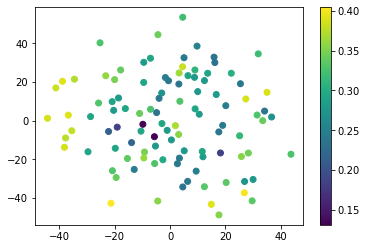

In [48]:
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=bv_array)
cbar = plt.colorbar()

In [49]:
disp_array = np.concatenate([np.array(disp_methyl), np.array(disp_amine)])

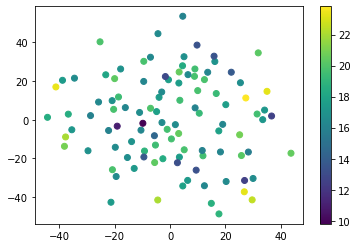

In [50]:
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=disp_array)
cbar = plt.colorbar()

In [51]:
sa_array = np.concatenate([np.array(methyl_sa), np.array(amine_sa)])

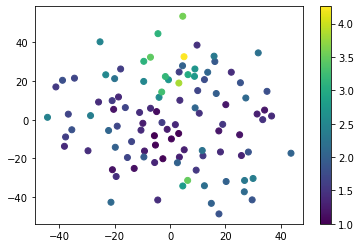

In [52]:
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=sa_array)
cbar = plt.colorbar()